In [1]:
!pip install -q ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.1 MB/s eta 0:00:00
time: 307 µs (started: 2024-02-01 08:58:35 +00:00)


In [2]:
!python -c "import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'"

time: 4.83 s (started: 2024-02-01 08:58:35 +00:00)


In [3]:
!pip install -qqq git+https://github.com/huggingface/transformers --progress-bar off
!pip install -qqq git+https://github.com/huggingface/datasets --progress-bar off
!pip install -qqq git+https://github.com/huggingface/peft --progress-bar off
!pip install -qqq git+https://github.com/huggingface/accelerate --progress-bar off
!pip install -qqq --upgrade bitsandbytes --progress-bar off
!pip install -qqq git+https://github.com/huggingface/trl --progress-bar off
!pip install -qqq --upgrade safetensors --progress-bar off
!pip install -qqq -U flash-attn --progress-bar off
!pip install -qqq evaluate --progress-bar off
!pip install -qqq gputil psutil --progress-bar off
!pip install -qqq wandb --progress-bar off



  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
time: 2min 31s (started: 2024-02-01 08:58:40 +00:00)


In [4]:
# Initialize wandb
import wandb
import GPUtil
import psutil
wandb.login()  # You might need to log in to your wandb account

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

time: 2min 19s (started: 2024-02-01 09:01:12 +00:00)


In [5]:
wandb.init(project="llama2_vs_llama_pro_tweet_summarization", entity="drishtisharma96505", group='llama2_7b_1e-4_gradnorm_0.3_warmupratio_0.05', name='llama2_7b_gradnorm_0.3_warmupratio_0.05')

wandb: Currently logged in as: drishtisharma96505. Use `wandb login --relogin` to force relogin


time: 5.92 s (started: 2024-02-01 09:03:41 +00:00)


In [6]:
from warnings import filterwarnings
import json
import re
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import transformers
import datasets
from transformers import (
    AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer,
    DataCollatorForLanguageModeling, EarlyStoppingCallback, pipeline, logging, set_seed, BitsAndBytesConfig
)
from huggingface_hub import notebook_login, login
from datasets import Dataset, load_dataset, load_metric
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from random import randrange
import evaluate
import bitsandbytes as bnb
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, AutoPeftModelForCausalLM
import wandb

filterwarnings('ignore')
set_seed(42)


time: 11.2 s (started: 2024-02-01 09:03:47 +00:00)


In [7]:
library_versions = {
    "Python": sys.version.split()[0],
    "NumPy": np.__version__,
    "Pandas": pd.__version__,
    "Datasets": datasets.__version__,
    "Transformers": transformers.__version__,
    "Torch": torch.__version__,
    "Evaluate": evaluate.__version__,
}

for name, version in library_versions.items():
    print(name.rjust(15), ":", version)

         Python : 3.10.12
          NumPy : 1.23.5
         Pandas : 1.5.3
       Datasets : 2.16.2.dev0
   Transformers : 4.38.0.dev0
          Torch : 2.1.0+cu121
       Evaluate : 0.4.1
time: 9.77 ms (started: 2024-02-01 09:03:58 +00:00)


# **Loading the Dataset**

In [8]:
dataset = load_dataset("Salesforce/dialogstudio", "TweetSumm")


time: 22.4 s (started: 2024-02-01 09:03:58 +00:00)


In [9]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 879
    })
    validation: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 110
    })
    test: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 110
    })
})
time: 1.04 ms (started: 2024-02-01 09:04:20 +00:00)


In [10]:
dataset["train"][0]["original dialog info"]

'{"summaries": {"extractive_summaries": [[{"is_agent": false, "sentences": ["So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn\\u2019t recognise either source anymore for some reason."]}, {"is_agent": true, "sentences": ["To start, can you tell us the software versions your iPhone and Apple Watch are running currently?"]}, {"is_agent": false, "sentences": ["@AppleSupport My iPhone is on 11.1.2, and my watch is on 4.1."]}], [{"is_agent": false, "sentences": ["So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn\\u2019t recognise either source anymore for some reason."]}, {"is_agent": true, "sentences": ["To start, can you tell us the software versions your iPhone and Apple Watch are running currently?"]}], [{"is_agent": false, "sentences": ["So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn\\u2019t recognise either source anymore for some reason."]}, {"is_agent": true, "s

time: 2.68 ms (started: 2024-02-01 09:04:20 +00:00)


In [11]:
json.loads(dataset["train"][0]["original dialog info"])

{'summaries': {'extractive_summaries': [[{'is_agent': False,
     'sentences': ['So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason.']},
    {'is_agent': True,
     'sentences': ['To start, can you tell us the software versions your iPhone and Apple Watch are running currently?']},
    {'is_agent': False,
     'sentences': ['@AppleSupport My iPhone is on 11.1.2, and my watch is on 4.1.']}],
   [{'is_agent': False,
     'sentences': ['So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason.']},
    {'is_agent': True,
     'sentences': ['To start, can you tell us the software versions your iPhone and Apple Watch are running currently?']}],
   [{'is_agent': False,
     'sentences': ['So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reas

time: 3.28 ms (started: 2024-02-01 09:04:20 +00:00)


In [12]:
json.loads(dataset["train"][0]["original dialog info"])["summaries"]

{'extractive_summaries': [[{'is_agent': False,
    'sentences': ['So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason.']},
   {'is_agent': True,
    'sentences': ['To start, can you tell us the software versions your iPhone and Apple Watch are running currently?']},
   {'is_agent': False,
    'sentences': ['@AppleSupport My iPhone is on 11.1.2, and my watch is on 4.1.']}],
  [{'is_agent': False,
    'sentences': ['So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason.']},
   {'is_agent': True,
    'sentences': ['To start, can you tell us the software versions your iPhone and Apple Watch are running currently?']}],
  [{'is_agent': False,
    'sentences': ['So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason.']},
   {'is_agent': T

time: 3.13 ms (started: 2024-02-01 09:04:21 +00:00)


In [13]:
json.loads(dataset["train"][0]["original dialog info"])["summaries"]["extractive_summaries"]

[[{'is_agent': False,
   'sentences': ['So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason.']},
  {'is_agent': True,
   'sentences': ['To start, can you tell us the software versions your iPhone and Apple Watch are running currently?']},
  {'is_agent': False,
   'sentences': ['@AppleSupport My iPhone is on 11.1.2, and my watch is on 4.1.']}],
 [{'is_agent': False,
   'sentences': ['So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason.']},
  {'is_agent': True,
   'sentences': ['To start, can you tell us the software versions your iPhone and Apple Watch are running currently?']}],
 [{'is_agent': False,
   'sentences': ['So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason.']},
  {'is_agent': True,
   'sentences': ['Have you tried

time: 3.18 ms (started: 2024-02-01 09:04:21 +00:00)


In [14]:
json.loads(dataset["train"][0]["original dialog info"])["summaries"]["abstractive_summaries"]

[['Customer enquired about his Iphone and Apple watch which is not showing his any steps/activity and health activities.',
  'Agent is asking to move to DM and look into it.'],
 ['The customer has a problem.',
  'The agent in a very professional way tries to help the client.'],
 ['Health and activity functions are not working with the smartwatch and phone.',
  'Asks if the customer had restarted the items, offers to take this to DM to help resolve the issue.']]

time: 2.5 ms (started: 2024-02-01 09:04:21 +00:00)


In [15]:
DEFAULT_SYSTEM_PROMPT = """
Below is a conversation between a human and an AI agent. Write a summary of the conversation.
""".strip()

def generate_training_prompt(conversation: str, summary: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    prompt = (
        f"### Instruction: {system_prompt}\n\n"
        f"### Input:\n{conversation.strip()}\n\n"
        f"### Response:\n{summary}"
    )
    return prompt.strip()


time: 948 µs (started: 2024-02-01 09:04:21 +00:00)


In [16]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@[^\s]+", "", text)
    text = re.sub(r"\s+", " ", text)
    return re.sub(r"\^[^ ]+", "", text)

def create_conversation_text(data_point):
    text = []
    for item in data_point["log"]:
        user = clean_text(item["user utterance"]).strip()
        agent = clean_text(item["system response"]).strip()
        text.append(f"user: {user}\nagent: {agent}")
    return "\n".join(text)

def generate_text(data_point):
    summaries = json.loads(data_point["original dialog info"])["summaries"]["abstractive_summaries"]
    summary = " ".join(summaries[0])
    conversation_text = create_conversation_text(data_point)
    return {
        "conversation": conversation_text,
        "summary": summary,
        "text": generate_training_prompt(conversation_text, summary)
    }


time: 1.98 ms (started: 2024-02-01 09:04:21 +00:00)


In [17]:
dataset["train"][0]

{'original dialog id': 'b065262210783596c1fe79466b8f8985',
 'new dialog id': 'TweetSumm--train--1',
 'dialog index': 1,
 'original dialog info': '{"summaries": {"extractive_summaries": [[{"is_agent": false, "sentences": ["So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn\\u2019t recognise either source anymore for some reason."]}, {"is_agent": true, "sentences": ["To start, can you tell us the software versions your iPhone and Apple Watch are running currently?"]}, {"is_agent": false, "sentences": ["@AppleSupport My iPhone is on 11.1.2, and my watch is on 4.1."]}], [{"is_agent": false, "sentences": ["So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn\\u2019t recognise either source anymore for some reason."]}, {"is_agent": true, "sentences": ["To start, can you tell us the software versions your iPhone and Apple Watch are running currently?"]}], [{"is_agent": false, "sentences": ["So neither my iPhone nor my

time: 4.12 ms (started: 2024-02-01 09:04:21 +00:00)


In [18]:
example = generate_text(dataset["train"][0])

time: 1.47 ms (started: 2024-02-01 09:04:21 +00:00)


In [19]:
print(example)

{'conversation': 'user: So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason. Any ideas? please read the above.\nagent: Let’s investigate this together. To start, can you tell us the software versions your iPhone and Apple Watch are running currently?\nuser: My iPhone is on 11.1.2, and my watch is on 4.1.\nagent: Thank you. Have you tried restarting both devices since this started happening?\nuser: I’ve restarted both, also un-paired then re-paired the watch.\nagent: Got it. When did you first notice that the two devices were not talking to each other. Do the two devices communicate through other apps such as Messages?\nuser: Yes, everything seems fine, it’s just Health and activity.\nagent: Let’s move to DM and look into this a bit more. When reaching out in DM, let us know when this first started happening please. For example, did it start after an update or after installing a certain app?', 'summa

In [20]:
print(example["text"])

### Instruction: Below is a conversation between a human and an AI agent. Write a summary of the conversation.

### Input:
user: So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason. Any ideas? please read the above.
agent: Let’s investigate this together. To start, can you tell us the software versions your iPhone and Apple Watch are running currently?
user: My iPhone is on 11.1.2, and my watch is on 4.1.
agent: Thank you. Have you tried restarting both devices since this started happening?
user: I’ve restarted both, also un-paired then re-paired the watch.
agent: Got it. When did you first notice that the two devices were not talking to each other. Do the two devices communicate through other apps such as Messages?
user: Yes, everything seems fine, it’s just Health and activity.
agent: Let’s move to DM and look into this a bit more. When reaching out in DM, let us know when this first started happe

In [21]:
print(example["summary"])

Customer enquired about his Iphone and Apple watch which is not showing his any steps/activity and health activities. Agent is asking to move to DM and look into it.
time: 1.31 ms (started: 2024-02-01 09:04:21 +00:00)


# **Preprocessing Dataset**

In [22]:
def process_dataset(data: Dataset):
    return data.shuffle(seed=42).map(generate_text).remove_columns(["original dialog id", "new dialog id", "dialog index", "original dialog info", "log", "prompt"])

time: 711 µs (started: 2024-02-01 09:04:21 +00:00)


In [23]:
dataset["train"] = process_dataset(dataset["train"])
dataset["validation"] = process_dataset(dataset["validation"])
dataset["test"] = process_dataset(dataset["test"])

time: 476 ms (started: 2024-02-01 09:04:21 +00:00)


In [24]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['conversation', 'summary', 'text'],
        num_rows: 879
    })
    validation: Dataset({
        features: ['conversation', 'summary', 'text'],
        num_rows: 110
    })
    test: Dataset({
        features: ['conversation', 'summary', 'text'],
        num_rows: 110
    })
})
time: 1.62 ms (started: 2024-02-01 09:04:21 +00:00)


# **Length Distributions of Text Features in Dataset**

In [25]:
def calculate_lengths_statistics(dataset, feature_name):
    lengths = [len(row[feature_name]) for row in dataset]
    max_length = max(lengths)
    min_length = min(lengths)
    avg_length = sum(lengths) / len(lengths)
    return max_length, min_length, avg_length

def print_statistics(dataset_dict):
    for subset_name in ['train', 'validation', 'test']:
        print(f"Statistics for {subset_name} subset:")
        for feature_name in ['conversation', 'summary', 'text']:
            max_length, min_length, avg_length = calculate_lengths_statistics(dataset_dict[subset_name], feature_name)
            print(f"  {feature_name}: Max Length = {max_length}, Min Length = {min_length}, Average Length = {avg_length:.2f}")

print_statistics(dataset)


Statistics for train subset:
  conversation: Max Length = 3232, Min Length = 360, Average Length = 1014.86
  summary: Max Length = 515, Min Length = 78, Average Length = 195.41
  text: Max Length = 3621, Min Length = 655, Average Length = 1349.27
Statistics for validation subset:
  conversation: Max Length = 1861, Min Length = 410, Average Length = 947.63
  summary: Max Length = 392, Min Length = 72, Average Length = 186.52
  text: Max Length = 2137, Min Length = 751, Average Length = 1273.15
Statistics for test subset:
  conversation: Max Length = 2746, Min Length = 356, Average Length = 1083.49
  summary: Max Length = 390, Min Length = 96, Average Length = 185.46
  text: Max Length = 3025, Min Length = 632, Average Length = 1407.95
time: 118 ms (started: 2024-02-01 09:04:21 +00:00)


# **Visualizing Length Distributions of Text Features in Dataset**

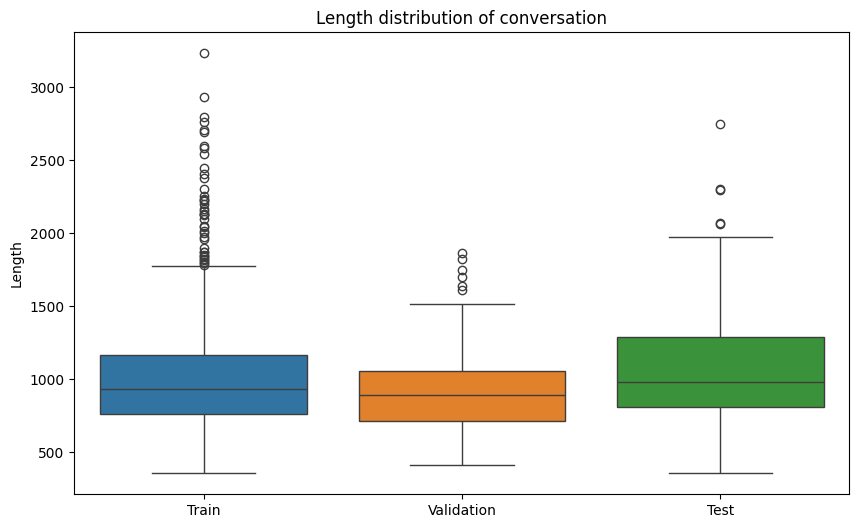

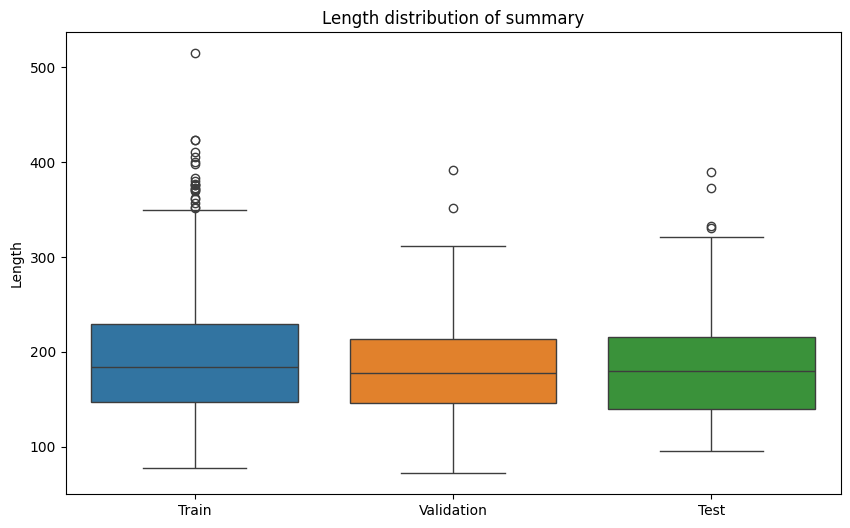

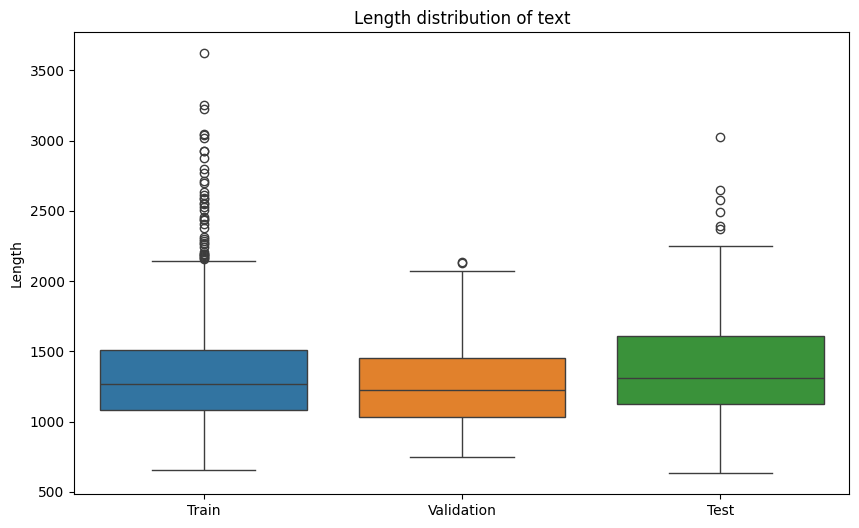

time: 914 ms (started: 2024-02-01 09:04:21 +00:00)


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def collect_lengths(dataset_dict, feature_name):
    lengths = {
        'train': [len(row[feature_name]) for row in dataset_dict['train']],
        'validation': [len(row[feature_name]) for row in dataset_dict['validation']],
        'test': [len(row[feature_name]) for row in dataset_dict['test']]
    }
    return lengths

def plot_feature_lengths(dataset_dict, feature_name):
    data = collect_lengths(dataset_dict, feature_name)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=[data['train'], data['validation'], data['test']])
    plt.xticks([0, 1, 2], ['Train', 'Validation', 'Test'])
    plt.title(f'Length distribution of {feature_name}')
    plt.ylabel('Length')
    plt.show()


for feature in ['conversation', 'summary', 'text']:
    plot_feature_lengths(dataset, feature)


# **Loading and Quantizing the Model**

In [27]:
# Hugging Face model id
model_id = "NousResearch/Llama-2-7b-hf"

time: 874 µs (started: 2024-02-01 09:04:22 +00:00)


In [28]:
# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

time: 2.26 ms (started: 2024-02-01 09:04:22 +00:00)


In [29]:
# Load model
print("########## Loading Model for 4-bit Quantization ##########")
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, use_cache=True, device_map="auto", use_flash_attention_2=True)


########## Loading Model for 4-bit Quantization ##########


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

time: 46.4 s (started: 2024-02-01 09:04:22 +00:00)


In [30]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    

In [31]:
print(model.config)

LlamaConfig {
  "_name_or_path": "NousResearch/Llama-2-7b-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "ro

In [32]:
!pip install -q sentencepiece

time: 5.32 s (started: 2024-02-01 09:05:09 +00:00)


In [33]:
# Loading the Tokenizer
print("############### Loading the Tokenizer ###############")
tokenizer = AutoTokenizer.from_pretrained(model_id)

############### Loading the Tokenizer ###############


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

time: 3.65 s (started: 2024-02-01 09:05:14 +00:00)


In [34]:
print(tokenizer)

LlamaTokenizerFast(name_or_path='NousResearch/Llama-2-7b-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
time: 1.14 ms (started: 2024-02-01 09:05:18 +00:00)


In [35]:
tokenizer.pad_token = tokenizer.eos_token

time: 671 µs (started: 2024-02-01 09:05:18 +00:00)


In [36]:
print(tokenizer)

LlamaTokenizerFast(name_or_path='NousResearch/Llama-2-7b-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
time: 921 µs (started: 2024-02-01 09:05:18 +00:00)


In [37]:
print("###############  Setting up LoRA configuration and preparing the model for training using LoRA  ###############")

###############  Setting up LoRA configuration and preparing the model for training using LoRA  ###############
time: 810 µs (started: 2024-02-01 09:05:18 +00:00)


In [38]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

r = 64
LORA_DROPOUT = 0.0
LORA_ALPHA = 64

# LoRA config based on QLoRA paper
peft_config = LoraConfig(
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        r=r,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "down_proj", "gate_proj", "up_proj"]
)


# prepare model for training
model = prepare_model_for_kbit_training(model)

time: 29.5 ms (started: 2024-02-01 09:05:18 +00:00)


In [39]:
print("###############  Model prepared for training with PEFT ###############")

###############  Model prepared for training with PEFT ###############
time: 1.92 ms (started: 2024-02-01 09:05:18 +00:00)


In [40]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    

In [41]:
print(model.config)

LlamaConfig {
  "_name_or_path": "NousResearch/Llama-2-7b-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "ro

In [42]:
print("###############  Creating PEFT Model with Configured Settings  ###############")
model = get_peft_model(model, peft_config)

###############  Creating PEFT Model with Configured Settings  ###############
time: 2.07 s (started: 2024-02-01 09:05:18 +00:00)


In [43]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit

In [44]:
print(model.config)

LlamaConfig {
  "_name_or_path": "NousResearch/Llama-2-7b-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "ro

In [45]:
model.print_trainable_parameters()

trainable params: 159,907,840 || all params: 6,898,323,456 || trainable%: 2.3180681656919973
time: 8.68 ms (started: 2024-02-01 09:05:20 +00:00)


In [46]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=baa84fe29286d36904927801b2fcd1a9cfc291bc0ed4e0a295f460993d8eb5f7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
time: 6.33 s (started: 2024-02-01 09:05:20 +00:00)


In [47]:
rouge_score = load_metric("rouge")

time: 1.43 s (started: 2024-02-01 09:05:26 +00:00)


In [48]:
import time


time: 1.04 ms (started: 2024-02-01 09:05:28 +00:00)


ROUGE-1 counts the number of common unigrams (words) between the generated and reference summaries, resulting in a score of 2 out of 5.

ROUGE-2 counts the number of common bigrams (consecutive word pairs) between the generated and reference summaries. In this case, there are no common bigrams, so the score is 0 out of 4.

ROUGE-L computes the length of the longest common subsequence (LCS) between the generated and reference summaries. Here, the LCS is "machine learning," so the score is 2 out of 4.

ROUGE-W is similar to ROUGE-L but assigns weights to words based on their positions. The score is 1.25 out of 4, reflecting the weighted LCS "machine learning."

ROUGE-S measures the overlap of skip-bigrams (word pairs with one word in between) between the generated and reference summaries. The score is 1 out of 4.

ROUGE-N (2-gram) computes the overlap of 2-grams (consecutive pairs of words) between the generated and reference summaries. The score is 1 out of 3.

In [49]:
import numpy as np
from transformers import TrainingArguments
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Import evaluate from py-rouge package
import evaluate

# Initialize ROUGE metric using py-rouge
rouge_metric = evaluate.load("rouge")

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return logits.argmax(dim=-1)

def compute_metrics(eval_preds, tokenizer):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100 in the preds as we can't decode them
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)

    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(pred.strip()) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.strip()) for label in decoded_labels]

    # Calculate ROUGE scores using py-rouge
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results and convert to percentage
    result = {key: value * 100 for key, value in result.items()}

    #smoothing function
    smoothing_function = SmoothingFunction().method4

    # Calculate BLEU score for n-grams (1 to 4)
    bleu_scores = []
    for n in range(1, 5):
        weights = (1/n,) * n
        bleu_scores_n = [corpus_bleu([[ref]], [pred], weights=weights, smoothing_function=smoothing_function) for ref, pred in zip(decoded_labels, decoded_preds)]
        bleu_scores.append(sum(bleu_scores_n) / len(bleu_scores_n))

    # Calculate mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    gen_len = np.mean(prediction_lens)

    # You can process the rouge_scores, bleu_scores, and gen_len as needed
    return {
        "rouge_scores": result,
        "bleu_scores": bleu_scores,
        "gen_len": gen_len
    }


# Declare training arguments
training_args = TrainingArguments(
    output_dir="llama2-7bb-tweet-summarization-gradnorm-0.3-warmupratio-0.05",
    evaluation_strategy="epoch",
    do_eval=True,
    save_strategy="epoch",
    learning_rate=1e-4,
    logging_strategy='epoch', # log according to log_steps
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=7,
    per_device_train_batch_size=4,
    greater_is_better=True,
    # metric_for_best_model='eval_loss',
    max_grad_norm=0.3,
    load_best_model_at_end=True,
    lr_scheduler_type="cosine",
    group_by_length=True,
    save_safetensors=True,
    warmup_ratio=0.05,
    report_to="wandb",
    fp16=True,
    seed=42

)

# Declare trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    dataset_text_field="text",
    max_seq_length=2048,
    compute_metrics=lambda eval_preds: compute_metrics(eval_preds, tokenizer),  # Pass the tokenizer
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)


time: 2.62 s (started: 2024-02-01 09:05:28 +00:00)


In [50]:
# Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
5.285 GB of memory reserved.
time: 3.2 ms (started: 2024-02-01 09:05:30 +00:00)


In [51]:
start_time = time.time()  # Start timer

trainer_stats = trainer.train()

end_time = time.time()  # End timer
training_duration = end_time - start_time

print(f"Training Time: {training_duration} minutes")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


Epoch,Training Loss,Validation Loss,Rouge Scores,Bleu Scores,Gen Len
1,1.979700,1.846788,"{'rouge1': 92.58753211785933, 'rouge2': 78.56005630365634, 'rougeL': 67.90431046147724, 'rougeLsum': 92.60062258669173}","[0.9044331868078556, 0.8935689766031644, 0.8701723917264629, 0.8432837507770929]",463.018182
2,1.687500,1.831720,"{'rouge1': 93.57745806777827, 'rouge2': 79.20734399292829, 'rougeL': 68.03949913123978, 'rougeLsum': 93.56573169703795}","[0.9260232753232301, 0.9151369981183058, 0.8909296719649512, 0.8630015430201563]",463.018182
3,1.360900,1.943966,"{'rouge1': 93.64149561116312, 'rouge2': 78.9369863604149, 'rougeL': 67.28929677118091, 'rougeLsum': 93.6354094969574}","[0.933089623937576, 0.9213474707086045, 0.8961256783117583, 0.8671119660431741]",463.018182
4,0.997300,2.147936,"{'rouge1': 93.77098210043772, 'rouge2': 78.72676191106424, 'rougeL': 66.61685782420736, 'rougeLsum': 93.77132525696588}","[0.9407524092990022, 0.9287706231907287, 0.9027163186452807, 0.8726978389893866]",463.018182
5,0.682800,2.362441,"{'rouge1': 93.76850681087201, 'rouge2': 78.54959646542315, 'rougeL': 65.96739684743356, 'rougeLsum': 93.76918986163282}","[0.9447432833130077, 0.9323421216849288, 0.9057018192399795, 0.8750402029132044]",463.018182
6,0.466200,2.667516,"{'rouge1': 93.85846920408349, 'rouge2': 78.2490547871314, 'rougeL': 65.29853641567857, 'rougeLsum': 93.85718380561036}","[0.9469562557636547, 0.9345062357610694, 0.9072329702581828, 0.8757492563086158]",463.018182
7,0.359400,2.835984,"{'rouge1': 93.92075452911438, 'rouge2': 78.28015883656892, 'rougeL': 64.88738306318788, 'rougeLsum': 93.91572652306441}","[0.9489359800839542, 0.9362845242017266, 0.908851614503138, 0.877219164400539]",463.018182


Training Time: 4320.739306211472 minutes
time: 1h 12min (started: 2024-02-01 09:05:30 +00:00)


In [55]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

4320.1101 seconds used for training.
72.0 minutes used for training.
Peak reserved memory = 17.582 GB.
Peak reserved memory for training = 12.297 GB.
Peak reserved memory % of max memory = 44.439 %.
Peak reserved memory for training % of max memory = 31.081 %.
time: 4.25 ms (started: 2024-02-01 10:18:15 +00:00)


In [56]:
wandb.log({
    'Model Name': 'NousResearch/Llama-2-7b-hf',
    'Model Configuration': 'alpha = {}, lora_dropout = {}, r = {}'.format(LORA_ALPHA, LORA_DROPOUT, r),
    'Dataset': 'Salesforce/dialogstudio',
    'Key Features': 'Flash Attention 2, No Unsloth, No NEFTune',
    'Hardware Specifications': 'GPU = {}, Max memory = {} GB'.format(gpu_stats.name, max_memory),
    'Training Time (minutes)': training_duration,
    'Training Arguments': training_args.to_dict(),
    'Memory Stats': {
        'Start GPU Memory (GB)': start_gpu_memory,
        'Peak Reserved Memory (GB)': used_memory,
        'Peak Reserved Memory for Training (GB)': used_memory_for_lora,
        'Peak Reserved Memory % of Max Memory': used_percentage,
        'Peak Reserved Memory for Training % of Max Memory': lora_percentage
    },
    'Training Runtime (seconds)': trainer_stats.metrics['train_runtime'],
    'Peak Reserved Memory (GB)': used_memory  # Added missing parameter
})

time: 3.23 ms (started: 2024-02-01 10:18:15 +00:00)


In [57]:
from huggingface_hub import notebook_login
notebook_login()

time: 17.1 ms (started: 2024-02-01 10:18:16 +00:00)


In [58]:
trainer.push_to_hub()

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/640M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DrishtiSharma/llama2-7bb-tweet-summarization-gradnorm-0.3-warmupratio-0.05/commit/6f36bca38ae955586dbae5d457d20fa0841d13d8', commit_message='End of training', commit_description='', oid='6f36bca38ae955586dbae5d457d20fa0841d13d8', pr_url=None, pr_revision=None, pr_num=None)

time: 56 s (started: 2024-02-01 10:18:36 +00:00)
